The goal of this notebook is to provide a quick introduction to some tools for analyzing images. We'll dig into many of these topics in more detail in the next part of the lab. 

For this exercise, we'll use some reduced data from the McDonald 30" telescope of the NGC2264 star cluster. 

In [1]:
# import the necessities 
import numpy as np 
import photutils
from matplotlib import pyplot as plt

from astropy.io import fits

In [2]:
# read in the data 
hdu = fits.open('/Users/mr82/teaching/data_for_ASTR230/example_data/NGC2264_V_long.fits')  
image = hdu[0].data

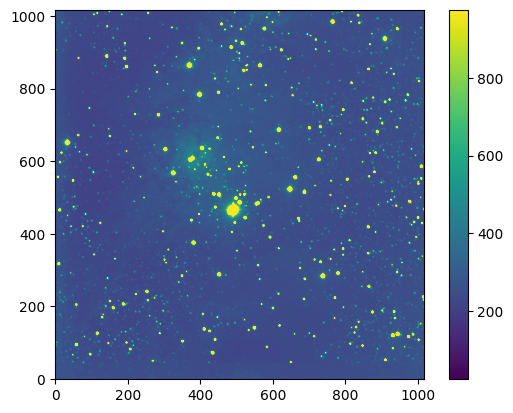

In [3]:
plt.imshow(image, origin='lower', vmin=25, vmax=975)
plt.colorbar()

One can visualize a CCD image as a 3D surface, where the x,y plane is the pixel coordinates (that map to sky coordinates like RA and Dec) and the z-direction is number of counts. A stellar image appears like a ‘mountain’. To measure the brightness of a star, the goal is to measure the volume of the mountain -- the total counts from the star. To do this we must also estimate the height of the ‘plain’ that the mountain sits on.

First, let's look at a surface plot. 

In [4]:
xarray = np.vstack([np.arange(image.shape[1])]*image.shape[0])
yarray = np.tile(np.arange(image.shape[0])[:,np.newaxis], image.shape[1])

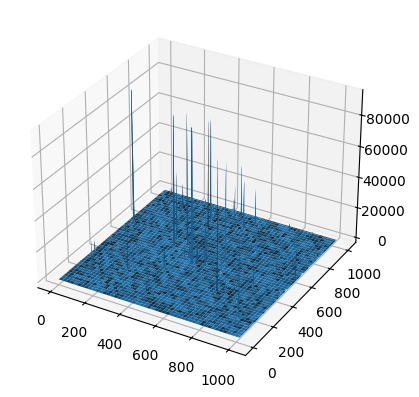

In [5]:
# Plot the surface to visualize the 'mountains' 
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(xarray, yarray, image)#, vmin=Z.min() * 2, cmap=cm.Blues)


We can zoom in on just one star to get a better idea of what the profile of the star looks like. 

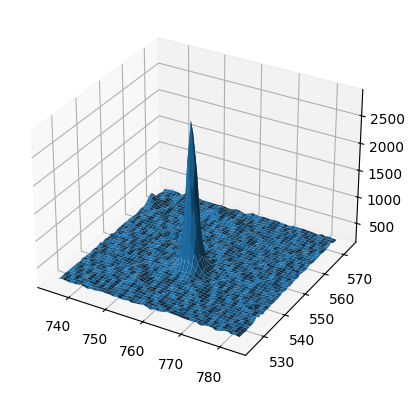

In [6]:
# Plot the surface to visualize the 'mountains' 
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(xarray[525:574,735:784], yarray[525:574,735:784], image[525:574,735:784])#, vmin=Z.min() * 2, cmap=cm.Blues)


To measure the emission from the star without contamination from other emission in the region (like what?), let's make a simple estimate of the image background and subtract that off. 

In [7]:
image -= np.nanmedian(image)  

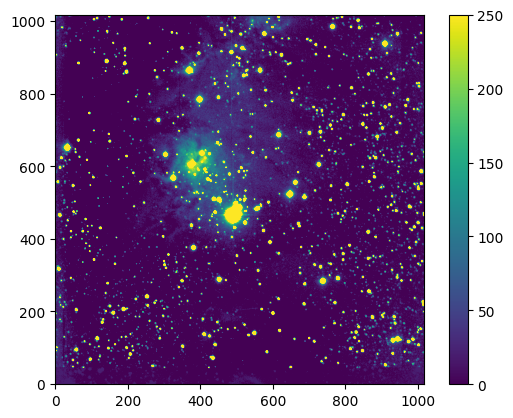

In [8]:
plt.imshow(image, origin='lower', vmin=0, vmax=250)
plt.colorbar()

Notice the nebular emission - it's more apparent with this image scaling. (not convinced? play with the scaling of the original image either in python or ds9.) Subtracting off a single number as an estimate of the background is a start but for careful measurements, local variations also need to be taken into account. 

## Measuring stars

There are several things we might want to measure about a star -- its position and brightness, for example. One of the most basic parameters is the full-width half maximum (FWHM) as a measure of the seeing. 

Let's look at a moderately bright star. To pick one, I opened the image in ds9 and looked for a bright (but not saturated) star that was relatively isolated. 

Display the image, then overplot a point to make sure the (x,y) coordinates sit on top of the star of interest. 

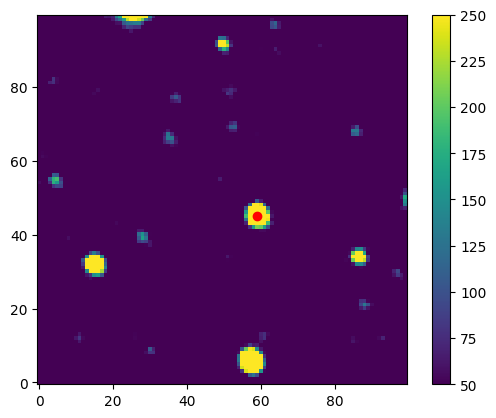

In [9]:
# starting coordinates 
xstar = 759
ystar = 545

# show only a portion of the image so it is easier to see the star
plt.imshow(image[500:600,700:800], origin='lower', vmin=50, vmax=250)
# note: we trimmed the image so we have to correct to the new origin
plt.plot([xstar-700], [ystar-500], 'o', color='red')
plt.colorbar()

Take a look at the 1D intensity profile of the star. You can do this in ds9 with regions (using a 'line' and selecting 'Plot 2D' under the 'Analysis' drop-down menu). We can do the same thing in python by plotting a slice of the data that goes through the star. 

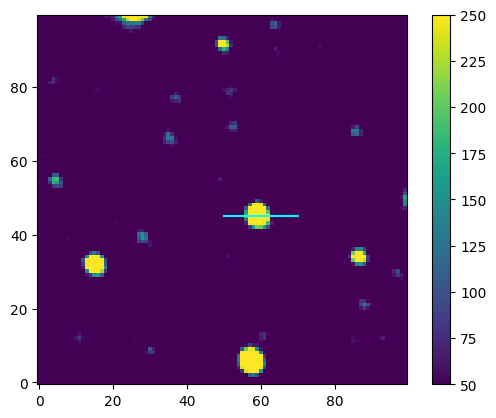

In [10]:
# draw the line on the image to make sure it's where we want it to be 
plt.imshow(image[500:600,700:800], origin='lower', vmin=50, vmax=250)
# note: we trimmed the image so the (x,y) values are relative to the new origin
plt.plot([50,70],[ystar-500,ystar-500], color='cyan')
plt.colorbar()

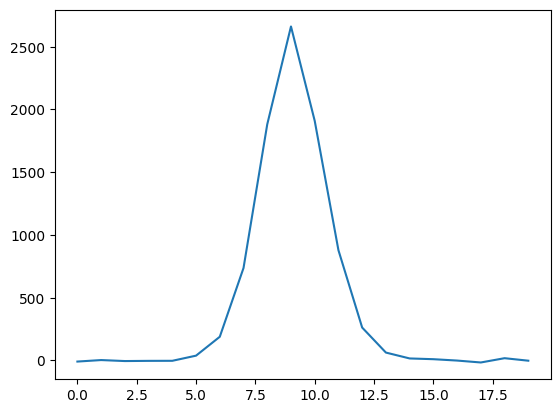

In [11]:
# plot the slice through the star
plt.plot(image[ystar,750:770])

We can estimate the FWHM by hand to get a rough idea of the number we expect when we use another code to compute it. 

In [12]:
# find half the maximum 
np.max(image[546,750:770])/2.

1201.6538195168098

In [13]:
# find the pixel location of the peak
np.argmax(image[546, 750:770]) + 750  # Why do we add 750?

759

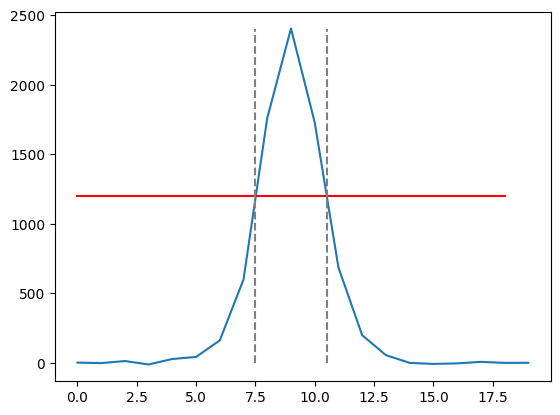

In [14]:
# plot the profile 
plt.plot(image[546,750:770])
# plot a line showing half the maximum
plt.plot([0,18], [1200,1200], color='red')
# eyeballing the width at half the maximum
plt.plot([7.5,7.5], [0,2400], color='gray', linestyle='dashed')
plt.plot([10.5,10.5], [0,2400], color='gray', linestyle='dashed')

This is a painfully slow and inefficient way to estimate the FWHM but it gives us some intuition for what a more precisely measured FWHM should be. 

Let's use photutils to get a quicker and more accurate estimate. 

### Using photutils to find the centroid and FWHM

Photutils is a powerful package for measuring the brightness of stars. It includes several tools to detect stars, measure their positions, FWHMs, brightness, etc. 

You can find the documentation on the web and explore the capabilities that photutils has to offer: 
https://photutils.readthedocs.io/en/stable/index.html

Start by measuring the centroid position of the star. To start, we used the integer pixel coordinates of the star estimated by-eye. The centroid is a more precise estimate of the center of light of the star and results in a sub-pixel position. As always, there are a few different ways we can do this (you can read about the options available in photutils in the documentation: https://photutils.readthedocs.io/en/stable/reference/centroids_api.html). Let's start with `centroid_quadratic`. 

In [15]:
from photutils.centroids import centroid_quadratic
xycen = centroid_quadratic(image, xpeak=xstar, ypeak=ystar)
print(xycen)  

[759.06280145 545.16449144]


Next, use the centroid position to extract the radial profile of the star.

In [16]:
from photutils.profiles import RadialProfile
edge_radii = np.arange(25)
rp = RadialProfile(image, xycen, edge_radii, mask=None)


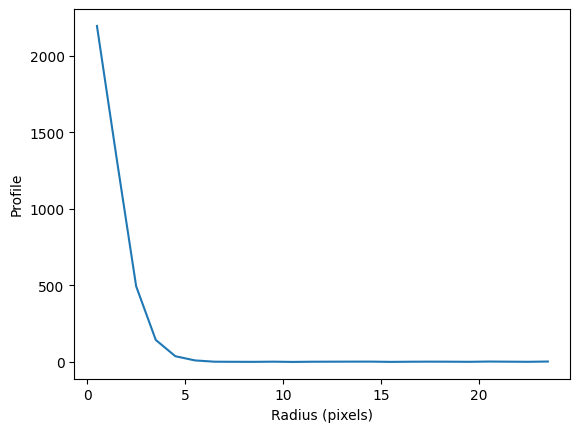

In [17]:
rp.plot(label='Radial Profile')

Look familiar? Note that this is a _radial_ profile, so it's only half the star. 

Now that we've measured the radial profile, we can easily output the FWHM. 

In [18]:
rp.gaussian_fwhm

3.361330398217219

### using more than one star to estimate the FWHM 

Ideally, the FWHM of one star will be a good estimate of the FWHM of the other stars in the image since the seeing is a property of the weather / observing conditions. 

We can check this by measuring the FWHM of several stars in the image and comparing them. 

To do this, we'll use one of the automated star detection tools in photutils. 
For more information, look at the documentation: https://photutils.readthedocs.io/en/stable/user_guide/detection.html

We'll use a slightly larger sub-image so we have multiple stars. 

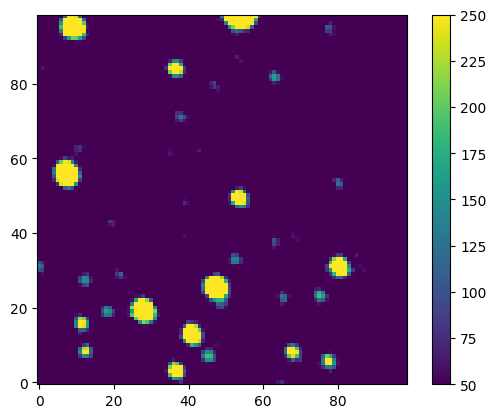

In [19]:
sm_im = image[450:549,750:849]

plt.imshow(sm_im, origin='lower', vmin=50, vmax=250)
plt.colorbar()

We only want stars that are well-detected, that is, stars with sufficient counts to be above the noise and have a well-measured profile. To do this, we'll set a threshold that sources must be above to be considered stars. Let's compute some image statistics to figure out the threshold value. 

In [20]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(sm_im, sigma=3.0)  

Next, we'll run the DAOStarFinder to automatically detect stars in the image. Take a look at the documentation to see how the algorithm works and what parameters can be tuned: https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html

In [21]:
from photutils.detection import DAOStarFinder

# use the FWHM calculated above as the estimated FWHM for the data
# set a threshold that detected stars must be at least 5-sigma above the background
daofind = DAOStarFinder(fwhm=rp.gaussian_fwhm, threshold=5.*std)  
sources = daofind(sm_im)  

for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)  

 id xcentroid ycentroid sharpness ...   peak    flux    mag   daofind_mag
--- --------- --------- --------- ... ------- -------- ------ -----------
  1     36.57      3.10      0.41 ...  620.51  6039.35  -9.45       -2.13
  2     77.52      5.71      0.44 ...  305.17  3068.98  -8.72       -1.33
  3     45.45      7.01      0.38 ...  191.11  2074.83  -8.29       -0.82
  4     12.53      8.29      0.42 ...  259.70  2446.50  -8.47       -1.22
  5     67.85      8.16      0.40 ...  363.62  3687.71  -8.92       -1.53
  6     41.01     12.93      0.42 ... 1171.06 11604.19 -10.16       -2.81
  7     11.49     15.77      0.45 ...  322.81  2980.13  -8.69       -1.41
...       ...       ...       ... ...     ...      ...    ...         ...
 24     37.99     70.93      0.47 ...  130.09  1098.24  -7.60       -0.44
 25     47.23     79.63      0.38 ...   83.28   739.61  -7.17       -0.05
 26     63.13     81.63      0.41 ...  164.38  1473.95  -7.92       -0.78
 27     36.56     83.98      0.42 ... 

Notice that there are several other parameters output by the DAOStarFinder, including sharpess and roundness estimates for all sources. You can play around with these parameters to see if the changes results in a better or worse selection of things that actually look like (single) stars to your eyes. Better yet, plot out these parameters. Do the sharpness and roundness values tend to cluster around a particular number? 

To see all the parameters output by DAOStarFinder, you can use `pprint_all()`. 

In [22]:
sources.pprint_all()

 id xcentroid ycentroid sharpness roundness1 roundness2 npix   peak    flux    mag   daofind_mag
--- --------- --------- --------- ---------- ---------- ---- ------- -------- ------ -----------
  1     36.57      3.10      0.41      -0.32      -0.04   25  620.51  6039.35  -9.45       -2.13
  2     77.52      5.71      0.44      -0.37       0.03   25  305.17  3068.98  -8.72       -1.33
  3     45.45      7.01      0.38       0.12      -0.06   25  191.11  2074.83  -8.29       -0.82
  4     12.53      8.29      0.42       0.24      -0.12   25  259.70  2446.50  -8.47       -1.22
  5     67.85      8.16      0.40      -0.42       0.02   25  363.62  3687.71  -8.92       -1.53
  6     41.01     12.93      0.42      -0.25       0.08   25 1171.06 11604.19 -10.16       -2.81
  7     11.49     15.77      0.45      -0.27      -0.05   25  322.81  2980.13  -8.69       -1.41
  8     18.36     18.93      0.39      -0.29      -0.06   25  166.97  1631.44  -8.03       -0.78
  9     27.95     19.23      0

Do a quick visual check to make sure the things the algorithm identified as stars actually look like stars. 

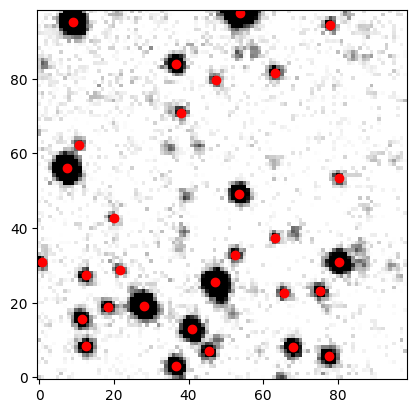

In [23]:
plt.imshow(sm_im, origin='lower', vmin=0, vmax=100, cmap='gray_r')
plt.scatter(sources['xcentroid'], sources['ycentroid'], color='red')

If everything looks reasonable, they we can use the positions as inputs to measure the FWHM. If any of the red points lie in what appears to be empty space or something that is clearly not round, go back and change the detection parameters. 

In [24]:
from photutils import psf

xys = list(zip(sources['xcentroid'], sources['ycentroid']))

fwhms = psf.fit_fwhm(sm_im, xypos=xys, fit_shape=7)
fwhms

array([2.91195953, 3.11402505, 3.3464657 , 2.85811953, 2.99157061,
       3.10118638, 2.95906161, 2.95020574, 3.0773272 , 2.47263368,
       2.87953882, 3.08747939, 2.78230466, 2.27866923, 2.85621001,
       3.08753045, 2.75034474, 2.25811461, 2.37583823, 2.98611448,
       2.45820055, 3.07729542, 8.71001915, 2.83136042, 2.7026095 ,
       2.74223188, 2.94922338, 3.09284429, 2.81971433, 3.40070165])

In [25]:
np.nanmedian(fwhms)

2.9305914559647346

In [26]:
np.nanmean(fwhms)

3.063630007343964

These are pretty close to the FWHM we found for the bright star but somewhat lower -- why? Notice that the detection algorithm picked up several of the fainter stars in the image. Try changing the `threshold` to a higher and lower value (e.g., `10.*std` and/or `3.*std`). This is why we want a 'moderately bright' star -- one that is well-detected (but not saturated) so that we have a good measure of it's brightness. 

Thinking about your own data, which of these parameters can you probably leave the same as in this example? Which do you need to remeasure for your own image[s]? Be careful when running the software out of the box -- the defaults in example code won't necessarily be appropriate for your data. 

Finally, did the two methods give the same FWHM for the moderately bright star we picked at the beginning? 

## Photometry

Aperture photometry works by adding up all the counts in an aperture centered on the star (the mountain), and subtracting off the ‘average’ height of the background determined from the pixel values in an annulus around the star (the ‘plain’).

We can try it using the sources detected with DAOStarFinder. 

In [27]:
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats

# measure the counts in an aperture of radius r and positions (x,y) where we detected stars 
apertures = CircularAperture(xys, r=np.nanmedian(fwhms))  
# measure the counts in the sky in an annulus around the stars; r_in and r_out are the inner and outer radii of the annuli
annuli = CircularAnnulus(xys, r_in=6, r_out=10)
# use these apertures to measure the photometry or the brightness of a point-like object in the image
phot_table = aperture_photometry(sm_im, apertures)  

for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output

print(phot_table) 

 id  xcenter   ycenter  aperture_sum
--- --------- --------- ------------
  1 36.571708 3.1017516    6132.0231
  2 77.523883 5.7058723    3209.8399
  3 45.450057 7.0068378    2139.0742
  4 12.533698  8.294625    2556.4317
  5 67.847074 8.1634477    3665.4463
  6 41.010518 12.926526    11752.425
  7 11.487604 15.765959    3114.0852
...       ...       ...          ...
 24 37.987336 70.926182    1114.3851
 25 47.232798 79.626273    805.62637
 26 63.128231 81.626204    1525.1026
 27 36.563008  83.98438    5117.2197
 28 9.0606102 95.269516      26886.2
 29 77.789298 94.447241     994.2628
 30 53.699116 97.711218    48941.919
Length = 30 rows


Plot the apertures and annuli on the image. 

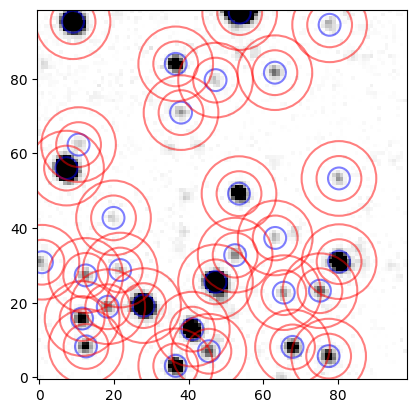

In [28]:
plt.imshow(sm_im, cmap='Greys', origin='lower', vmin=0, vmax=250)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
annuli.plot(color='red', lw=1.5, alpha=0.5)

Ideally, there would be no stars in the sky annuli around any of the stars in your image. In practice, this can be hard to avoid. 

Why is there a gap between the aperture on the star and the sky annulus? How does one decide the correct aperture sizes? We'll discuss this more in the next part of the lab. 

## Looking at not-star things

What about other kinds of objects in images? For example, star-forming regions like NGC2264 tend to have some leftover gas hanging around. One thing we might want to know is "what is the distribution of the gas?" If we change the intensity scaling on the image, we can start to see more of the nebular emission. 

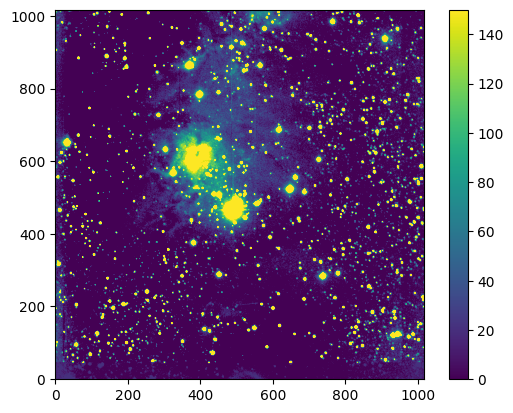

In [29]:
plt.imshow(image, origin='lower', vmin=0, vmax=150)
plt.colorbar()

Take a slice through the image to look at the intensity profile of the nebulosity. 

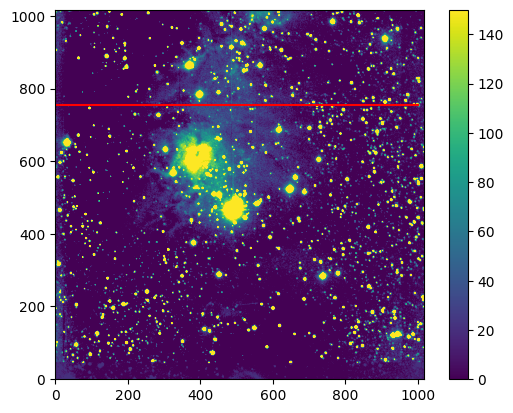

In [30]:
plt.imshow(image, origin='lower', vmin=0, vmax=150)
plt.colorbar()

# pick a region, any region
plt.plot([0,1000], [755,755], color='red')

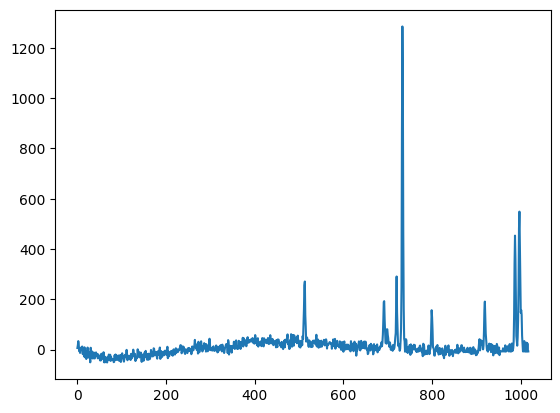

In [31]:
# plot the slice through the image
plt.plot(image[755,:])

Notice that there are several stars along this slice. How could you use the tools in the beginning of this notebook to remove the stars from this portion of the image? 

For now, we can zoom in on the y-axis to see the intensity variations along the slice

(-100.0, 200.0)

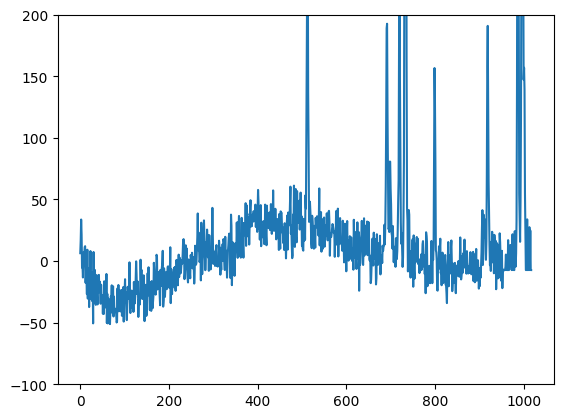

In [32]:
plt.plot(image[755,:])
plt.ylim([-100,200])

Try combining a few pixels in the y-direction when you take a slice through the image. How does that change the profile? 

Finally, for the interested reader, a few things you can explore from here. 

Don't like the way the data look (i.e. can you still see the column of bad pixels in the center of the chip?)? You can try your hand at reducing it yourself using the raw data frames and calibration files available on google drive. 

Curious how the same field looks when imaged with a different exposure time? Try these same techniques on the 'NGC2264_V_short' image available on google drive. 